In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=f41ca5687bc3c5d4ca3784b17d40e39f7ed62f9aa77206de343927eb1052ccb6
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "himanshuagarwal190" # username from the json file
os.environ['KAGGLE_KEY'] = "33e9024be1057cf493169f3a3a19c631" # key from the json file
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 99% 281M/285M [00:03<00:00, 88.5MB/s]
100% 285M/285M [00:03<00:00, 88.1MB/s]


In [3]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [0]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcef1dd5b70>]],
      dtype=object)

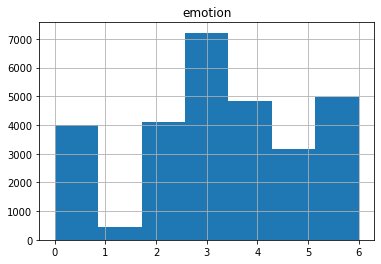

In [6]:
train.hist(bins=7)

In [0]:
def load_data(csv):
  pixels = []
  emotion = []
  for index, row in tqdm(csv.iterrows()):
    pix = row['pixels'].split(' ')
    pix = [int(i) for i in pix]
    pixels.append(pix)
    emotion.append(int(row['emotion']))
  return pixels, emotion

In [9]:
x_train, y_train = load_data(train)
x_train = np.array(x_train)/255
y_train = np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)

28709it [00:19, 1478.27it/s]


In [0]:
from sklearn.utils import class_weight
class_wt = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=28)

In [0]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [21]:
model = Sequential()
#1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=x_train.shape[1:], padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))
model.add(Dropout(0.3))
#2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
#3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2))
model.add(Dropout(0.4))
#4
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ck = ModelCheckpoint('face_weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
re_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18

In [0]:
model.fit(x_train, y_train, batch_size=32, epochs=25, verbose=1, callbacks=[ck, re_lr],
          validation_data=(x_valid,y_valid), class_weight=class_wt)

Train on 22967 samples, validate on 5742 samples
Epoch 1/25
22967/22967 [==============================] - 67s 3ms/step - loss: 0.9134 - acc: 0.6527 - val_loss: 1.0970 - val_acc: 0.6116

Epoch 00001: val_loss did not improve from 1.09505
Epoch 2/25
22967/22967 [==============================] - 68s 3ms/step - loss: 0.9144 - acc: 0.6493 - val_loss: 1.0967 - val_acc: 0.6122

Epoch 00002: val_loss did not improve from 1.09505
Epoch 3/25
22967/22967 [==============================] - 67s 3ms/step - loss: 0.9169 - acc: 0.6491 - val_loss: 1.0972 - val_acc: 0.6108

Epoch 00003: val_loss did not improve from 1.09505
Epoch 4/25
22967/22967 [==============================] - 67s 3ms/step - loss: 0.9125 - acc: 0.6519 - val_loss: 1.0976 - val_acc: 0.6116

Epoch 00004: val_loss did not improve from 1.09505
Epoch 5/25
22967/22967 [==============================] - 67s 3ms/step - loss: 0.9137 - acc: 0.6494 - val_loss: 1.0970 - val_acc: 0.6113

Epoch 00005: val_loss did not improve from 1.09505
Epoch 

In [0]:
model_json = model.to_json()

In [0]:
import os

In [0]:
with open('cnn_model.json', mode='w') as json_file:
  json_file.write(model_json)

In [32]:
y_train[:5]

array([6, 3, 3, 2, 4])